In [45]:
import numpy as np
import casadi as ca
import yaml

from quadrotor import Quadrotor

In [46]:
quad = Quadrotor('./quad.yaml')

In [47]:
class WayPointOpt():
    def __init__(self, quad:Quadrotor, wp_num):
        self._quad = quad
        self._dynamics = self._quad.dynamics()

        self._wp_num = wp_num
        self._N_per_wp = 20 # opt param
        self._Herizon = self._wp_num*self._N_per_wp

        self._X_dim = self._dynamics.size1_in(0)
        self._U_dim = self._dynamics.size1_in(1)
        self._X_lb = self._quad._X_lb
        self._X_ub = self._quad._X_ub
        self._U_lb = self._quad._U_lb
        self._U_ub = self._quad._U_ub

        self._DTs = ca.SX.sym('DTs', self._wp_num)
        self._Xs = ca.SX.sym('Xs', self._X_dim, self._Herizon)
        self._Us = ca.SX.sym('Us', self._U_dim, self._Herizon)
        self._WPs_p = ca.SX.sym('WPs_p', 3, self._wp_num)
        self._WPs_v = ca.SX.sym('WPs_v', 3, self._wp_num)
        # self._WPs_yaw = ca.SX.sym("WPs_yaw", 2, self._wp_num)
        self._X_init = ca.SX.sym('X_init', self._X_dim)
        self._v_end = ca.SX.sym('v_end', 3)

        self._cost_Co = ca.diag([3,1,1,2]) # opt param
        self._cost_WP_p = ca.diag([1,1,1]) # opt param
        self._cost_WP_v = ca.diag([100,100,100]) # opt param
        self._cost_end_v = ca.diag([1,1,1]) # opt param

        self._opt1_option = {
            'verbose': False,
            'ipopt.tol': 1e-3,
            'ipopt.acceptable_tol': 1e-3,
            'ipopt.max_iter': 10000,
            'ipopt.warm_start_init_point': 'yes',
            # 'ipopt.print_level': 0,
        }
        self._opt2_option = {
            'verbose': False,
            # 'ipopt.tol': 1e-2,
            # 'ipopt.acceptable_tol': 1e-8,
            'ipopt.max_iter': 1000,
            'ipopt.warm_start_init_point': 'yes',
            'ipopt.print_level': 0
        }

        #################################################################
        self._nlp_x_x = []
        self._nlp_lbx_x = []
        self._nlp_ubx_x = []

        self._nlp_x_u = []
        self._nlp_lbx_u = []
        self._nlp_ubx_u = []

        self._nlp_x_t = []
        self._nlp_lbx_t = []
        self._nlp_ubx_t = []

        self._nlp_g_dyn = []
        self._nlp_lbg_dyn = []
        self._nlp_ubg_dyn = []

        self._nlp_g_wp_p = []
        self._nlp_lbg_wp_p = []
        self._nlp_ubg_wp_p = []

        # self._nlp_g_wp_v = []
        # self._nlp_lbg_wp_v = []
        # self._nlp_ubg_wp_v = []

        self._nlp_g_end_v = []
        self._nlp_lbg_end_v = []
        self._nlp_ubg_end_v = []

        # self._nlp_g_wp_yaw = []
        # self._nlp_lbg_wp_yaw = []
        # self._nlp_ubg_wp_yaw = []

        self._nlp_g_quat = []
        self._nlp_lbg_quat = []
        self._nlp_ubg_quat = []

        self._nlp_p_xinit = [ self._X_init ]
        self._nlp_p_dt = []
        self._nlp_p_wp_p = []
        # self._nlp_p_wp_v = []
        self._nlp_p_end_v = [ self._v_end ]

        self._nlp_obj_minco = 0
        self._nlp_obj_time = 0
        self._nlp_obj_wp_p = 0
        # self._nlp_obj_wp_v = 0
        self._nlp_obj_end_v = 0
        self._nlp_obj_quat = 0

        ###################################################################

        for i in range(self._wp_num):
            self._nlp_x_x += [ self._Xs[:, i*self._N_per_wp] ]
            self._nlp_lbx_x += self._X_lb
            self._nlp_ubx_x += self._X_ub
            self._nlp_x_u += [ self._Us[:, i*self._N_per_wp] ]
            self._nlp_lbx_u += self._U_lb
            self._nlp_ubx_u += self._U_ub
            self._nlp_x_t += [ self._DTs[i] ]
            self._nlp_lbx_t += [0]
            self._nlp_ubx_t += [0.5]

            if i==0:
                self._nlp_g_dyn += [ self._Xs[:,0]-self._X_init-self._dynamics( self._X_init, self._Us[:,0] )*self._DTs[0] ]
            else:
                self._nlp_g_dyn += [ self._Xs[:,i*self._N_per_wp]-self._Xs[:,i*self._N_per_wp-1]-self._dynamics( self._Xs[:,i*self._N_per_wp-1], self._Us[:,i*self._N_per_wp] )*self._DTs[i] ]
            self._nlp_lbg_dyn += [ -0.0 for _ in range(self._X_dim) ]
            self._nlp_ubg_dyn += [  0.0 for _ in range(self._X_dim) ]

            self._nlp_g_wp_p += [ (self._Xs[:3,(i+1)*self._N_per_wp-1]-self._WPs_p[:,i]).T@(self._Xs[:3,(i+1)*self._N_per_wp-1]-self._WPs_p[:,i]) ]
            self._nlp_lbg_wp_p += [0]
            self._nlp_ubg_wp_p += [ 0.001 ]

            self._nlp_p_dt += [ self._DTs[i] ]
            self._nlp_p_wp_p += [ self._WPs_p[:,i] ]

            self._nlp_obj_minco += (self._Us[:,i*self._N_per_wp]-[-9.91,0,0,0]).T@self._cost_Co@(self._Us[:,i*self._N_per_wp]-[-9.91,0,0,0])
            self._nlp_obj_time += self._DTs[i]*self._N_per_wp
            self._nlp_obj_wp_p += (self._Xs[:3,(i+1)*self._N_per_wp-1]-self._WPs_p[:,i]).T@self._cost_WP_p@(self._Xs[:3,(i+1)*self._N_per_wp-1]-self._WPs_p[:,i])
            # self._nlp_obj_wp_p += (self._Xs[:3,(i+1)*self._N_per_wp-2]-self._WPs_p[:,i]).T@self._cost_WP_p@(self._Xs[:3,(i+1)*self._N_per_wp-2]-self._WPs_p[:,i])

            for j in range(1, self._N_per_wp):
                self._nlp_x_x += [ self._Xs[:, i*self._N_per_wp+j] ]
                self._nlp_lbx_x += self._X_lb
                self._nlp_ubx_x += self._X_ub
                self._nlp_x_u += [ self._Us[:, i*self._N_per_wp+j] ]
                self._nlp_lbx_u += self._U_lb
                self._nlp_ubx_u += self._U_ub

                self._nlp_g_dyn += [ self._Xs[:,i*self._N_per_wp+j]-self._Xs[:,i*self._N_per_wp+j-1]-self._dynamics( self._Xs[:,i*self._N_per_wp+j-1], self._Us[:,i*self._N_per_wp+j] )*self._DTs[i] ]
                self._nlp_lbg_dyn += [ -0.0 for _ in range(self._X_dim) ]
                self._nlp_ubg_dyn += [  0.0 for _ in range(self._X_dim) ]

                self._nlp_obj_minco += (self._Us[:,i*self._N_per_wp+j]-[-9.91,0,0,0]).T@self._cost_Co@(self._Us[:,i*self._N_per_wp+j]-[-9.91,0,0,0])
        
        self._nlp_g_end_v += [ (self._Xs[3:6,self._Herizon-1]-self._v_end).T@(self._Xs[3:6,self._Herizon-1]-self._v_end) ]
        self._nlp_lbg_end_v += [ 0 ]
        self._nlp_ubg_end_v += [ 0.01 ]
        
        self._nlp_obj_end_v += (self._Xs[3:6,self._Herizon-1]-self._v_end).T@self._cost_end_v@(self._Xs[3:6,self._Herizon-1]-self._v_end)


    def define_opt1(self):
        nlp_dect = {
            'f': self._nlp_obj_wp_p,
            'x': ca.vertcat(*(self._nlp_x_x+self._nlp_x_u)),
            'p': ca.vertcat(*(self._nlp_p_xinit+self._nlp_p_wp_p+self._nlp_p_end_v+self._nlp_p_dt)),
            'g': ca.vertcat(*(self._nlp_g_dyn)),
        }
        self._opt1_solver = ca.nlpsol('opt1', 'ipopt', nlp_dect, self._opt1_option)
        self._xu0 = np.zeros((self._X_dim+self._U_dim)*self._Herizon)
        for i in range(self._Herizon):
            self._xu0[i*self._X_dim+6] = 1
            self._xu0[self._Herizon*self._X_dim+i*self._U_dim] = -9.81

    def solve_opt1(self, xinit, wp_p, end_v):
        p = np.zeros(self._X_dim+3*self._wp_num+3+self._wp_num)
        p[:self._X_dim] = xinit
        p[self._X_dim:self._X_dim+3*self._wp_num] = wp_p
        p[self._X_dim+3*self._wp_num:self._X_dim+3*self._wp_num+3] = end_v
        p[self._X_dim+3*self._wp_num+3] = 0.1
        res = self._opt1_solver(
            x0=self._xu0,
            lbx=(self._nlp_lbx_x+self._nlp_lbx_u),
            ubx=(self._nlp_ubx_x+self._nlp_ubx_u),
            lbg=(self._nlp_lbg_dyn),
            ubg=(self._nlp_ubg_dyn),
            p=p
        )
        self._xu0 = res['x'].full().flatten()
        return res

    def define_opt2(self):
        nlp_dect = {
            'f': self._nlp_obj_end_v,
            'x': ca.vertcat(*(self._nlp_x_x+self._nlp_x_u)),
            'p': ca.vertcat(*(self._nlp_p_xinit+self._nlp_p_wp_p+self._nlp_p_end_v+self._nlp_p_dt)),
            'g': ca.vertcat(*(self._nlp_g_dyn)),
        }
        self._opt2_solver = ca.nlpsol('opt1', 'ipopt', nlp_dect, self._opt1_option)
        # self._xu0 = np.zeros((self._X_dim+self._U_dim)*self._Herizon)
        # for i in range(self._Herizon):
        #     self._xu0[i*self._X_dim+6] = 1
        #     self._xu0[self._Herizon*self._X_dim+i*self._U_dim] = -9.81

    def solve_opt2(self, xinit, wp_p, end_v):
        p = np.zeros(self._X_dim+3*self._wp_num+3+self._wp_num)
        p[:self._X_dim] = xinit
        p[self._X_dim:self._X_dim+3*self._wp_num] = wp_p
        p[self._X_dim+3*self._wp_num:self._X_dim+3*self._wp_num+3] = end_v
        p[self._X_dim+3*self._wp_num+3] = 0.1
        res = self._opt2_solver(
            x0=self._xu0,
            lbx=(self._nlp_lbx_x+self._nlp_lbx_u),
            ubx=(self._nlp_ubx_x+self._nlp_ubx_u),
            lbg=(self._nlp_lbg_dyn),
            ubg=(self._nlp_ubg_dyn),
            p=p
        )
        self._xu0 = res['x'].full().flatten()
        return res

    def define_opt3(self):
        nlp_dect = {
            'f': self._nlp_obj_wp_p+self._nlp_obj_end_v,
            'x': ca.vertcat(*(self._nlp_x_x+self._nlp_x_u)),
            'p': ca.vertcat(*(self._nlp_p_xinit+self._nlp_p_wp_p+self._nlp_p_end_v+self._nlp_p_dt)),
            'g': ca.vertcat(*(self._nlp_g_dyn)),
        }
        self._opt3_solver = ca.nlpsol('opt1', 'ipopt', nlp_dect, self._opt1_option)
        # self._xu0 = np.zeros((self._X_dim+self._U_dim)*self._Herizon)
        # for i in range(self._Herizon):
        #     self._xu0[i*self._X_dim+6] = 1
        #     self._xu0[self._Herizon*self._X_dim+i*self._U_dim] = -9.81

    def solve_opt3(self, xinit, wp_p, end_v):
        p = np.zeros(self._X_dim+3*self._wp_num+3+self._wp_num)
        p[:self._X_dim] = xinit
        p[self._X_dim:self._X_dim+3*self._wp_num] = wp_p
        p[self._X_dim+3*self._wp_num:self._X_dim+3*self._wp_num+3] = end_v
        p[self._X_dim+3*self._wp_num+3] = 0.1
        res = self._opt3_solver(
            x0=self._xu0,
            lbx=(self._nlp_lbx_x+self._nlp_lbx_u),
            ubx=(self._nlp_ubx_x+self._nlp_ubx_u),
            lbg=(self._nlp_lbg_dyn),
            ubg=(self._nlp_ubg_dyn),
            p=p
        )
        self._xu0 = res['x'].full().flatten()
        return res




In [48]:
opt = WayPointOpt(quad, 1)
opt.define_opt1()
opt.define_opt2()
opt.define_opt3()

In [78]:
xinit = np.array([0,0,0, 4,0,0, 1,0,0,0])
wp_p = np.array([5,0,0])
end_v = np.array([3,0,0])

In [56]:
res = opt.solve_opt1(xinit, wp_p, end_v)
res = opt.solve_opt2(xinit, wp_p, end_v)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1203
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      459

Total number of variables............................:      280
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      160
                     variables with only upper bounds:        0
Total number of equality constraints.................:      200
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [79]:
res = opt.solve_opt3(xinit, wp_p, end_v)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1203
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      462

Total number of variables............................:      280
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      160
                     variables with only upper bounds:        0
Total number of equality constraints.................:      200
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [80]:
x = res['x'].full().flatten()

us = np.zeros([4,opt._Herizon])
xs = np.zeros([10, opt._Herizon])

for i in range(opt._Herizon):
    us[:,i] = x[opt._Herizon*opt._X_dim+i*opt._U_dim:opt._Herizon*opt._X_dim+(i+1)*opt._U_dim]
    xs[:,i] = x[i*opt._X_dim:(i+1)*opt._X_dim]
    

In [68]:
res['f']

DM(1.09864e-07)

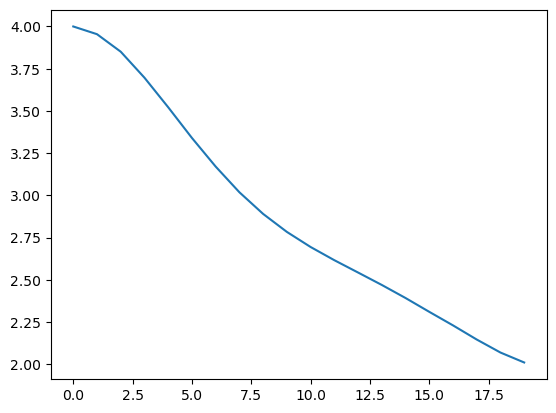

In [81]:
import matplotlib.pyplot as plt

plt.plot(xs[3,:])